# Example of discovery of viscoelastic models using an electronic analogue

In this notebook, a problem is tackled with the *DeepMoD* protocol concerning the ODEs involved in problems of linear viscoelasticity. Using a breadboard, arbitrary wave generator, and oscilloscope, alone with a variety of further electronic omponents, data analogous to strain and stress has already been measured and saved. This data is stored under '/data' proceeding from the top github directory. The notebook will proceed with the following structure:

1. Firstly, the data is loaded from .csv files and the record of the shunt resistance is used to convert the appropriate data series to current.

2. Next, this data will be processed such that it is scaled appropriately and a random subset of points are taken from the master data set.

3. After this, *DeepMoD* will be configured.

4. The *DeepMoD* protocol is run.

5. Finally, all results will be extracted, organised and saved.

Along the way, many additional steps will be present for analyzing the ongoing progress of the process, including in particular sections where numerical derivatives are used to check agreement between a given ODE and a given data set.

In [1]:
import os
import sys
from datetime import datetime
import pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

sys.path.append('../src')
import deepymod_torch.VE_params as VE_params
import deepymod_torch.VE_datagen as VE_datagen
from deepymod_torch.DeepMod import run_deepmod

# random seeding
np_seed = 4
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)

## Loading electronic data

The path to the data being tested is first defined. All data is saved as .csv files and hence the NumPy function `np.loadtxt(...)` is used. In experiments, 2 channels are measured using the oscilloscope. For both channels, the file created has 2 major columns, the first being time from the moment the saved data collection cycle was begun, and the second being the measured voltage at each time point. `np.loadtxt` automatically recognizes that rows beginning with a `#` are to be ignored. However the second row in the files created by the oscilloscope begin otherwise, even though it is a header title. As a result, the kwarg `skiprows` must be used.

The data collection from the oscilloscope should not necessarily be taken at face value. Measurements are performed such that the average voltage within a particular small time bin is displayed and saved for any particular time point, at least in the 'Normal' mode used here. In addition, a MHz frequency filter is available that has been used for some data sets during data collection, somewhat reducing noise levels.

In [2]:
general_path = '../data/Oscilloscope data electronics analogy/'
specific_path = 'GMM Funny f 0-2 sine amp 0-5 caps 220 33/' # It is precisely here that changes the data we are grabbing to test.
path = general_path + specific_path

channel_1_data = np.loadtxt(path+'Channel 1 total voltage.csv', delimiter=',', skiprows=3)
channel_2_data = np.loadtxt(path+'Channel 2 voltage shunt resistor.csv', delimiter=',', skiprows=3)

Details regarding the electronic model and manipulation profileare defined when the data is collected and so are not yet stated in this notebook. Mostly for the purpose of saving these details along with the analysis, a series of statements are now made which are statements of metadata from the perspective of this analysis.

The variable `omega` is not simply metadata, its value is important when later scaling the time series. Also, `mech_model` is necessary to for any conversion between the coeffcients in the expected or discovered model, and the electronic/mechanical parameters. `input_type` is also needed in the final stage of optional post analysis.

The nomenclature used remains faithful to the VE problem for the most part, `mech_model` is the name of the object, not, for instance, elec_model. An `input_type` of 'Strain' is appropriate when the manipulation variable was voltage, in fact always the case for any of the experiments performed with electronics.

In [27]:
input_type = 'Strain'
mech_model = 'GMM'
func_desc = 'Double inverted exponential recovery and sine'
omega_1 = 0.9; omega_2 = 7.2; omega_3 = 2.4*np.pi
amp_1 = 4; amp_2 = amp_1; amp_3 = 0.5

Particularly if the data being analyzed is of the form of a sinc curve where manipulation begins at $sinc(0)$, a large step discontinuity can exist at the beginning of manipulation. This is very challenging for the neural network to fit. As a result, the measured data must be clipped if any discontinuities are present. Manging where the data should be clipped is handled manually by plotting the measured voltage manipulation and adjusting the indices until the extreme buffer regions are clipped. The indices arrived at can then be used to clip the 3 data series of interest at the same points. Note, this means time will not often begin at 0, but this is not an issue for the model discovery process.

Note the appearance of a discontinuity in the data is actually unphysical, it is merely an artifact of discrete time measurements. The difficulty of the neural network to fit this rapid change is because it is so rapid, requiring a large amount of optimization.

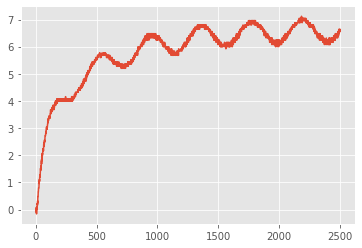

In [4]:
plt.plot(channel_1_data[470:-1089, 1])

In [5]:
lower = 470
upper = -1089

time_array = channel_1_data[lower:upper, :1] # Time
voltage_array = channel_1_data[lower:upper, 1:] # Voltage (Strain)
voltage_shunt_array = channel_2_data[lower:upper, 1:] # Precursor to Current (Stress)

The voltage over the so-labeled shunt resistor is recorded as `voltage_shunt_array`. This shunt resistor is in series with the block of circuitry imitating the linear viscoelastic model. As such, the current running through it is identical to the current running through the electronic model. To recover this current from the voltage measured in `voltage_shunt_array`, the resistance of this shunt resistor is used, as measured using a multimeter, with Ohm's law, $V=IR$ simply used for the conversion.

In [6]:
r_shunt = 10.2 # measured using multimeter
current_array = voltage_shunt_array/r_shunt # Current (Stress)

The now loaded voltage (strain) and current (stress) data for the electronic analogue model are now plotted.

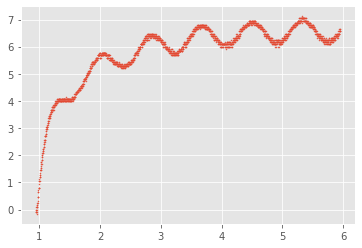

In [7]:
plt.plot(time_array, voltage_array, label='voltage', linestyle='None', marker='.', markersize=1)

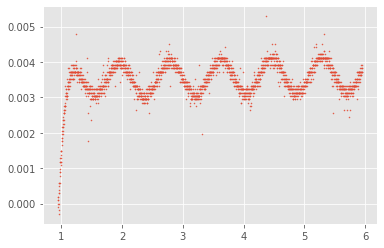

In [8]:
plt.plot(time_array, current_array, label='current', linestyle='None', marker='.', markersize=1)

## Data Treatment

### Scaling

Here the various scaling of the 3 data series occurs. In the case of the manipulation and response variables, this scaling is for the purpose of normalization, to bring the full range of magnitudes to span -1 to 1. This is optimal for performance of the optimisation process and for reducing the affects of disproportionately noisy data. In this scenario, there will be two target data series. These two data series may well be of different orders of magnitude and as a result fitting the noise in the larger of these data series may reduce the cost function more than fitting the smaller target at all. Normalization must occur to address this bias.

In the case of the time series data, the scaling is such as to bring the angular frequency of the sine function within sinc to an effective value of 1.2. This has been found to be empirically important. The exact reason for this is not known, but it corresponds to the scaling of a sinc curve where the average values of the different orders of derivative are most similar.

In [9]:
# 'normalising'
t_sf = omega_3/1.2
V_sf = 1/np.max(abs(voltage_array))
I_sf = 1/np.max(abs(current_array))
scaled_time_array = time_array*t_sf
scaled_voltage = voltage_array*V_sf
scaled_current = current_array*I_sf

# structuring
target_array = np.concatenate((scaled_voltage, scaled_current), axis=1)

### Extra: Predicting coefficients

The values `r_0`, `r_1`, `r_2` ($R_0$, $R_1$, $R_2$) are the measured resistance values of the resistors within the electronic analogue of the linear viscoelastic model chosen. These values are here recorded alongside `c_1`, `c_2` ($C_1$, $C_2$), the labeled capacitor values used in the given experiment. This is done purely in order to attempt to predict the coeffcients we expect DeepMoD to find. While capacitance is equivalent to the viscosity in this analogy, conductivity is analagous to elastic modulus, not resistance. As a result, in order to make predictions off of the electronic characteristics within the mechanical framework already established, the reciprocals of the measured resistances are recorded to get the equivalent elastic moduli.

In [10]:
r_0 = 1.99e3 # measured using multimeter (Ohms)
r_1 = 1.99e3 # measured using multimeter (Ohms)
r_2 = 1.99e3 # measured using multimeter (Ohms)
c_1 = 1e-3 # as labeled on component (Farads)
c_2 = 220e-6 # as labeled on component (Farads)

equiv_E = [1/r_0, 1/r_1, 1/r_2]
equiv_eta = [c_1, c_2]

The coefficients of the GDM for the data in the orginal unscaled case are calculated. The coeffcients returned take into account the established structure of the problem as posed to DeepMoD. For instance, the coefficient of the first derivative of voltage (strain) is considered 1 and not returned in this list. The returned list always lists the coefficients attached to voltage (strain) first, omitting the coefficient attached to the first derivative, then lists the coefficients attached to current (stress). Hence the list will always have an odd number of terms, the first item will always be the coefficient of voltage (strain), and the middle item will always be the coefficient of current (stress). Each additional capacitor included in the electronic  model definition increases the maximum order of derivative contained within the GDM by 1, and so the number of terms is (#capacitors + 1)*2 - 1.

The kwarg `print_expressions=True` can be added to show the equations used to relate `equiv_E` and `equiv_eta` to these coefficients.

For this and any use of functions within VE_params.py, the SymPy package must be installed.

In [11]:
pre_scaled_coeff_guess = VE_params.coeffs_from_model_params(equiv_E, equiv_eta, mech_model)
pre_scaled_coeff_guess

[0.411895543290222,
 0.358852459016393,
 2459.01639344262,
 3980.00000000000,
 714.116393442623]

Now taking into account the scaling applied to the data series, one further step is taken to arrive at the set of coeffcients DeepMoD is expected to find, based off its analysis of the scaled data series. The principle behind this step is that all terms in the ODE will be modified by a scaled factor made up of the scale factors of the data series involved in the term. To arrive at a GDM now valid for the scaled data series, the coeffcients must all be adjusted to reverse the scaling that has occurred for all the corresponding terms.

In [28]:
expected_coeffs = VE_params.scaled_coeffs_from_true(pre_scaled_coeff_guess, t_sf, V_sf, I_sf)
expected_coeffs

[0.157332508205185,
 0.939473540807112,
 0.698403475368854,
 2.95935228023794,
 1.39011658260537]

### Random sampling

Here a random subset of the recorded data is selected. A shuffled set of indices is generated and then an initial subset of these is used to pick the data for further analysis.

In [13]:
# random sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(scaled_time_array.size)
reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = target_array[reordered_row_indices, :][:number_of_samples]

## Configuration of DeepMoD

### Defining Library

Here, the function necessary for the computation of the library of terms for DeepMoD to select from is defined. This function will be called every epoch to generate the most up to date version of this library. In this example, the function computes and returns the derivatives of voltage (strain) and current (stress) up to a specified order using the automatic differentiation capabilities of the PyTorch framework for both variables. `auto_deriv(...)` is a general function for computing automatic derivatives up to a given order, and `mech_library_real(...)` organizes the results. Following the convention established within the structure of DeepMoD, the left hand side of the equation being discovered is a mandatory term and not part of the library. It is returned as its own object, enclosed within a list.

In [14]:
import torch.autograd as auto

def mech_library_real(inputs, **library_config):    
    '''
    Library function for the problem of linear viscoelasticity in the case where ...
    ... both strain and stress are measured quantities and thus targets for the netork to learn seperate mappings for.
    Calculates all derivatives up to a specified order for strain and stress.
    The first derivative of strain is returned as the mandatory guiding side of the discovered model.
    All terms calculated from strain in the returned library are multiplied by -1.
    
    Parameters
        inputs: 2-tuple
            A tuple of (prediction, data) where data is an Nx1 tensor, prediction is an Nx2 tensor, and ...
            ... gradients have been tracked from data to prediction.
            The tensor, data, is the input to a neural network, whereas prediction is the output.
        **library_config: kwargs packed into dict.
            All additional configuration options. Mandatory is the inclusion only of diff_order=int
            
    Returns
        [strain_t]: list
            Contains a Nx1 tensor
        theta: Nx(2*diff_order + 1) tensor
    '''
    
    prediction, data = inputs
    
    # Calculates the strain part of the library using automatic differentiation ...
    # ..., for now including the series of first strain derivative.
    # The first column of prediction is always strain.
    strain_derivs = auto_deriv(data, prediction[:, :1], library_config['diff_order'])
    strain_theta = torch.cat((prediction[:, :1], strain_derivs), dim=1)
    
    # Equivalently calculates the stress part of the library
    # The second column is always stress.
    stress_derivs = auto_deriv(data, prediction[:, 1:], library_config['diff_order'])
    stress_theta = torch.cat((prediction[:, 1:], stress_derivs), dim=1)
    
    strain_t = strain_theta[:, 1:2] # Extract the first time derivative of strain
    strain_theta = torch.cat((strain_theta[:, 0:1], strain_theta[:, 2:]), dim=1) # remove this before it gets put into theta
    strain_theta *= -1 # The negatives of all strain terms are included in the library so that all coefficients discovered should be positive.
    theta = torch.cat((strain_theta, stress_theta), dim=1)
    
    return [strain_t], theta


def auto_deriv(data, prediction, max_order):
    '''
    Computes all derivatives up to a specified order using automatic differentiation for a single input and a single output of a neural network.
    If it is desired to calculate the derivatives of different predictions wrt different data, this function must be called multiple times.
    
    Parameters
        data: Nx1 tensor
            An input to the neural network.
        prediction: Nx1 tensor
            An output of the neural network.
        max_order: float
            Specifies the order up to which derivatives should be calculated.

    Returns
        derivs: Nxmax_order tensor
            No column with the zeroth derivative (the prediction).
    '''
    
    # First derivative builds off prediction.
    derivs = auto.grad(prediction, data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]
    for _ in range(max_order-1):
        # Higher derivatives chain derivatives from first derivative.
        derivs = torch.cat((derivs, auto.grad(derivs[:, -1:], data, grad_outputs=torch.ones_like(prediction), create_graph=True)[0]), dim=1)
            
    return derivs

### Conversion to PyTorch tensors

The correctly processed arrays are converted here to Tensors, the class of object used by the PyTorch framework. The time tensor must have the requires_grad=True flag as derivatives with respect to time are required for computation of the library. The target does not require this flag as it is solely used when computing the MSE loss and no derivative with respect to it is ever required.

In [15]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

### Threshold definition

The threshold criterion is evaluated at the point of selecting terms and is evaluated by using the result of a function which invariably takes the arguments `coeff_vector_scaled, coeff_vector, optim_config`, where `coeff_vector_scaled` is the term-normalized set of coefficients at the point of sparse selection, `coeff_vector` is the actual values of the coefficients within the working model at the point of sparse selection, and `optim_config` is a dictionary that is soon to be defined for the purpose of configuring the optmization behavior of DeepMoD.

`coeff_vector_scaled` is compared to the value of the result to determine the sparse selection. In this example this value is always 0.05, regardless of the arguments, and so all args are packed and never used.

In [16]:
percent = 0.05
def thresh_pc(*args): # Keep as full function so that it can be pickled
    return percent

### Definition of configuration dictionaries

Here, a series of parameters are set that affect the neural network initialization, the optimization process, the behavior and functionality of the library evaluation, and the progress reporting.  Only `library_config` is strictly required to avoid errors as its elements are required for the functioning of the library function above. All other dictionaries contain only elements which will be added if missing and contain default values.

This dictionary is important for configuration of the process of building the library. In this example the elements within the dictionary are:

* `'library_func'`: The function defined in this notebook scripting the process of building the library.

* `'diff_order'`: The maximum order of derivative to be included in the library for both strain and stress. This value matches that defined above when calculating the manipulation variable library in advance.

* `'coeff_sign'`: Triggers 2 things within the *DeepMoD* protocol. First, all initial values for the coefficients in the working model are made to be positive. Second, this status is encouraged throughout the optimization process by the inclusion of the sign loss, or $L_{\pm}$, set to introduce a penalty for coefficients that become negative.


With `mech_library_real(...)` as the value for the `'library_func'` key, the element of key `'diff_order'` must be included. Seperately, the sign loss is required, and so for this reason `'coeff_sign'` is also a required element.

In [17]:
library_config = {'library_func': mech_library_real,
                  'diff_order': 3,
                  'coeff_sign': 'positive'}

This dictionary is important for configuration of the neural network initialization. Only elements for which the default values are not desired in this example are defined here.

* `'hidden_dim'`: Specifies the number of neurons in each hidden layer of the neural network.

In [18]:
network_config = {'hidden_dim': 30}

This dictionary is important for configuration of the optimization process. Only elements for which the default values are not desired in this example are defined here.

* `'lr_coeffs'`: The learning rate is an important parameter for the Adam optimizer used in *DeepMoD* and can also be called $\alpha$. Seperate values for the learning rates for the neural network parameters and coefficients in the working model can be defined. In this case the latter is set higher than its default.

* `'thresh_func'`: The function defined in the notebook scripting the evaluation of the threshold criterion.

* `'l1'`: The scale factor applied to the L1 loss term, sometimes also called $\lambda$. This term is used to encourage sparsity. In this example, it is set smaller than the default.

In [19]:
optim_config = {'lr_coeffs': 0.002,
                'thresh_func': thresh_pc,
                'l1': 10**-5,
                'max_iterations': 200001,
                'final_run_iterations': 20001}

This dictionary is important for configuration of progress reporting. Only elements for which the default values are not desired in this example are defined here.

* `'plot'`: Specifies whether plots of the target and working prediction should be displayed in an IPython environment.

In [20]:
report_config = {'plot': True}

## Launching DeepMoD

In [21]:
expected_coeffs # Extra: Displayed here purely for convenience of comparison with working model.

[0.157332508205185,
 0.939473540807112,
 0.698403475368854,
 2.95935228023794,
 1.39011658260537]

The training process is now launched using the wrapper function `run_deepmod(...)` which handles all configuration options so far defined. Aside from these dictionaries, only the input tensor and target need be supplied as arguments. In this example, all dictionaries are included as arguments, but in general only `library_config` is mandatory.

Upon completion, all training will have occurred both before and after the sparse selction and a model will have been reached. The returned object, `model`, is a member of a custom class of objects called DeepMod objects which are a subclass of the nn.Module class from PyTorch. The object is complex and contains the trained neural network amongst other characteristics such as many attributes relevant to the training process.

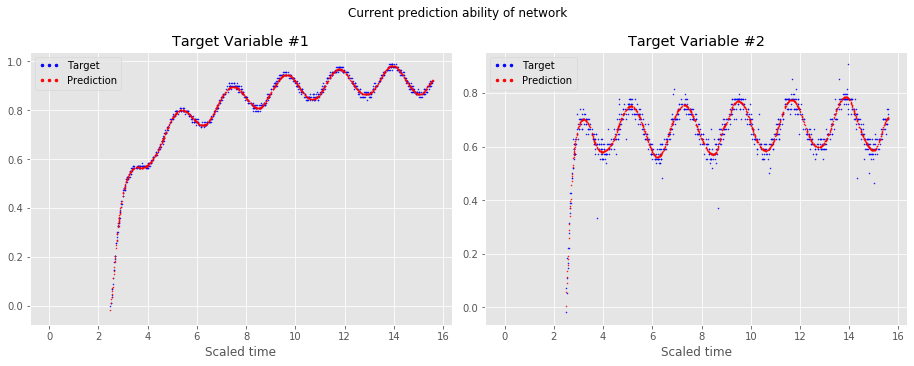

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |     Sign |
      20000    100.00%               0s   8.78e-04   8.76e-04   1.61e-06   0.00e+00   0.00e+00 
[Parameter containing:
tensor([[0.4439],
        [0.0421],
        [0.6024],
        [0.5899],
        [0.0027]], requires_grad=True)]


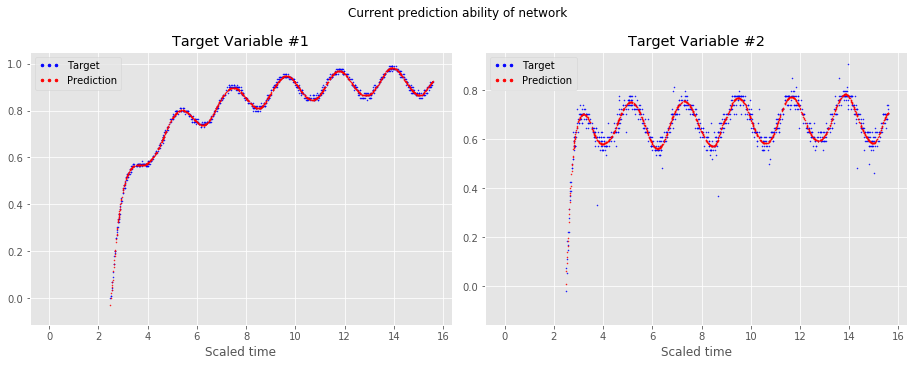

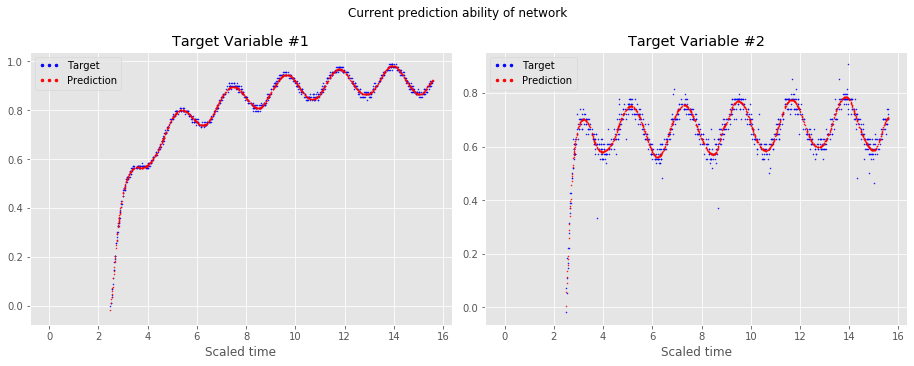

In [22]:
begin_timestamp = datetime.now()
model = run_deepmod(time_tensor, target_tensor, library_config, network_config, optim_config, report_config)

### Results

The discovered model is described below. `model.fit.coeff_vector_history` is an object which contains all coefficients in the working model both just before sparse selection and at the very end of training. In this example this means 2 column vectors are retained. The object is a list containing objects of class ParameterList from the PyTorch framework and so will not display readably unless additional conversion to lists is done. This is purely for display purposes.

`sparsity_mask_list_list` is the associated mask values both before sparse selection and at the very end of training, and identifies the terms each coefficient is associated with.

In [23]:
sparse_coeff_vector_list_list = model.fit.coeff_vector_history
[list(plist) for plist in sparse_coeff_vector_list_list]

[[Parameter containing:
  tensor([[4.2876e-01],
          [5.9985e-02],
          [6.3697e-05],
          [5.8276e-01],
          [5.9904e-01],
          [8.6643e-03],
          [2.6120e-03]], requires_grad=True)], [Parameter containing:
  tensor([[0.4439],
          [0.0421],
          [0.6023],
          [0.5899],
          [0.0027]], requires_grad=True)]]

In [24]:
sparsity_mask_list_list = model.fit.sparsity_mask_history
sparsity_mask_list_list

[[tensor([0, 1, 2, 3, 4, 5, 6])], [tensor([0, 1, 3, 4, 6])]]

## Organizing and saving all progress.

### Results Organization

The results of the training process are structured and saved in this section. Series data is organized into NumPy arrays, and any miscellaneous data is grouped into lists of keyed values, in similar fashion to dictionaries.

Some of the series and data saved here could be obtained without explicit saving if `model` is successfully pickled. However, for the sake of convenience, some redundant additional organization and saving occurs.

The below cell arranges results into two similar arrays. The prediction series data is saved both for the predictions obtained purely from the training data, and the predictions the neural network has learnt involving interpolation and perhaps a small amount of extrapolation, for all the data points in the master data set.

In [25]:
prediction_tensor = model.network(time_tensor)
prediction_array = np.array(prediction_tensor.detach())

time_tensor_post = torch.tensor(scaled_time_array, dtype=torch.float32, requires_grad=True)
full_prediction_tensor = model.network(time_tensor_post)
full_prediction_array = np.array(full_prediction_tensor.detach())

Next, arrays containing information on the coefficients associated with different models are organized. Saved are the scaled expected coefficients, the coefficients just before sparse selection, the final coefficients arrived at, the mask identifying these, and the final cofficients with the affects of scaling reversed.

If the model discovery process discovers the expected results, all these arrays will have the same shape except `pre_thresh_coeffs_array` which will always have a shape dictated by the size of the full library.

In [30]:
target_coeffs_array = np.array(expected_coeffs).reshape(-1,1)

pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach())

final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach())
sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0]).reshape(-1,1)
library_diff_order = library_config['diff_order']
unscaled_final_coeffs = VE_params.true_coeffs_from_scaled(final_coeffs_array, t_sf, V_sf, I_sf, mask=sparsity_mask_array, library_diff_order=library_diff_order)
true_coeffs_array = np.array(unscaled_final_coeffs).reshape(-1, 1)

Various data series included some of those just organized above are grouped into 2D arrays where comparible series of data make sense.

In [31]:
raw_series_data = np.concatenate((time_array, voltage_array, current_array), axis=1)
NN_series_data = np.concatenate((reduced_time_array, reduced_target_array, prediction_array), axis=1)
final_coeffs_data = np.concatenate((final_coeffs_array, true_coeffs_array, sparsity_mask_array), axis=1)

Next, any further data that describes the measured data and configuration process within this notebook are organized into themed lists, with keys explaining each datum as part of the same string.

In [32]:
raw_data_info_list = ['Model: '+mech_model, f'E: {equiv_E}', f'eta: {equiv_eta}', 'Input: '+input_type, 'Desc: '+func_desc, f'omega: {omega_1}, {omega_2}, {omega_3}', f'Amp: {amp_1}, {amp_2}, {amp_3}', f'R_shunt: {r_shunt}']
raw_data_info_list

['Model: GMM',
 'E: [0.0005025125628140704, 0.0005025125628140704, 0.0005025125628140704]',
 'eta: [0.001, 0.00022]',
 'Input: Strain',
 'Desc: Double inverted exponential recovery and sine',
 'omega: 0.9, 7.2, 7.5398223686155035',
 'Amp: 4, 4, 0.5',
 'R_shunt: 10.2']

In [33]:
treatment_info_list = [f'time_sf: {t_sf}', f'strain_sf: {V_sf}', f'stress_sf: {I_sf}']
treatment_info_list

['time_sf: 2.6179938779914944',
 'strain_sf: 0.1404494382022472',
 'stress_sf: 188.88888888888886']

In the below list, each of the different configuration dictionaries are saved. As dictionaries are mutable objects, these will contain any of the default values added when `run_deepmod(...)` was called.

In [34]:
config_dict_list = [f'library: {library_config}', f'network: {network_config}', f'optim: {optim_config}', f'report: {report_config}']
config_dict_list

["library: {'library_func': <function mech_library_real at 0x7fbe6af4df80>, 'diff_order': 3, 'coeff_sign': 1}",
 "network: {'hidden_dim': 30, 'pre_trained_network': None, 'layers': 4}",
 "optim: {'lr_coeffs': 0.002, 'thresh_func': <function thresh_pc at 0x7fbe6ac19ef0>, 'l1': 1e-05, 'max_iterations': 200001, 'final_run_iterations': 20001, 'PINN': False, 'kappa': 1, 'lr_nn': 0.001, 'betas': (0.9, 0.999), 'amsgrad': False, 'mse_only_iterations': None, 'use_lstsq_approx': False}",
 "report: {'plot': True, 'print_interval': 1000}"]

In [35]:
dt_string = begin_timestamp.strftime('%d/%m/%Y %H:%M:%S')
misc_list = ['date_stamp: '+dt_string, f'NumPy_seed: {np_seed}', f'Torch_seed: {torch_seed}']
misc_list

['date_stamp: 17/07/2020 15:27:37', 'NumPy_seed: 4', 'Torch_seed: 0']

### Saving

All data is now saved to the location specified below, within data/Results.

In [38]:
parent_folder = '../data/Results/Real/'
subfolder = f'{mech_model} {func_desc}'.replace('.', '-')

foldername = parent_folder + subfolder

In [39]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

The NumPy arrays are saved in the transferable .csv file format. The headers are an additional row of data at the top of the file preceeded by the `#` symbol. `np.loadtxt(..)` automatically understands this as headers and will not load this row as data, but alternative loaders may behave differently.

In [40]:
np.savetxt(foldername+'/raw_series_data.csv', raw_series_data, delimiter=',', header='Time, Strain, Stress')
np.savetxt(foldername+'/NN_series_data.csv', NN_series_data, delimiter=',', header='Time, Target (V), Target (I), Prediction (V), Prediction (I)')
np.savetxt(foldername+'/expected_coeffs.csv', target_coeffs_array, delimiter=',', header='Expected_coeffs')
np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_array, delimiter=',', header='Trained_Coeffs')
np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Unscaled, Sparsity_Mask')
np.savetxt(foldername+'/full_prediction.csv', full_prediction_array, delimiter=',', header='Full Prediction (V), Full Prediction (I)')

All lists are saved with each element on a seperate line.

In [44]:
with open(foldername+'/raw_info_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in raw_data_info_list)

In [45]:
with open(foldername+'/treatment_info_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in treatment_info_list)

In [46]:
with open(foldername+'/config_dict_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in config_dict_list)

In [47]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines(f'{line}\n' for line in misc_list)

The `model` object is pickled. If any lambda function objects are referred to, in dictionaries for example, this will fail. Fully defined functions do not hit this error, however pickling  does not saved the scripts associated with these functions, just the object identity, and so functions will need to be redefined for successful un-pickling.

In [48]:
with open(foldername+'/model.pickle', 'wb') as file:
    pickle.dump(model, file) # Will fail on dump if using lambda funcs, will fail on load if normal funcs that are not redefined.

### Rediscovering electronic model parameters if possible

Depending on the results of the model discovery process, it will not always be possible to recover an electronic model description from the discovered set of coefficients. For this reason, before this is attempted, all other results have been organized and saved. If the discovered model doesn't match the GDM pattern, it is possible that no solution to the set of simultaneous equations exist. One easy check implemented is that an exception is triggered immediately if the the number of coefficients in the discovered model is even (odd counting the assumed first derivative of strain).

However, even in the case a non-viable model is discovered, `model_params_from_coeffs(...)` may still run, but the results will be nonsense.

The returned model params will be relevant to the context of mechanical elastic moduli and viscosities, and will need further conversion to reach the discovered electronic parameters.

`recovered_mech_params` is a list of tuples. Each tuple is a seperate solution to the problem of simultaneous equations being solved. Most often there is only a single solution. All solutions are displayed in the cell output.

In [49]:
true_coeffs = list(true_coeffs_array.flatten())
recovered_mech_params = VE_params.model_params_from_coeffs(true_coeffs, mech_model)[0]
recovered_mech_params

KeyboardInterrupt: 

The conversion to electronic parameters here occurs, simply by finding the reciprocal of all elastic moduli recovered from the conversion from coefficients. The index of `recovered_mech_params[0]` selects which solution from above is now used going forward.

In [ ]:
recovered_elec_params = np.array(recovered_mech_params[0])
recovered_elec_params[:len(equiv_E)] = 1/recovered_elec_params[:len(equiv_E)]
recovered_elec_params

#### Saving

In [ ]:
recovered_mech_params_array = recovered_mech_params.reshape(-1,1)
np.savetxt(foldername+'/recovered_elec_params.csv', recovered_elec_params, delimiter=',', header='Recovered')

## Extra: Post analysis

In this section, a series of analyses are performed regarding the quality and interpretation of the results.

In [ ]:
# Convenience arrangements
predict_voltage_array, predict_current_array = full_prediction_array[:, 0], full_prediction_array[:, 1]

### Viewing the full predictive ability of the trained neural network

The neural network used by DeepMoD was trained only on a subset of the available training data. As a result, unexpected aberrations at points of effective interpolation and extrapolation may be present when a denser prediction is made based on the full input data. To observe if such aberrations are present, the two predictions are shown below against the full available training data. The predictions ideally should be sommoth curves that appear to denoise the full available training data. Obvious abberations at best imply that the following analysis may have otherwise unexpected incongruous results, and at worse may betray that insufficient training data was used if an incorrect model was also discovered.

In [ ]:
plt.plot(scaled_time_array, scaled_voltage, label='Full Target')
plt.plot(scaled_time_array, predict_voltage_array, label='Full Prediction')
plt.legend()
plt.title('Voltage')

In [ ]:
plt.plot(scaled_time_array, scaled_current, label='Full Target')
plt.plot(scaled_time_array, predict_current_array, label='Full Prediction')
plt.legend()
plt.title('Current')

### Comparison of GDM residuals with respect to predictions

In this analysis, the levels of agreement between the two models in question, the expected and the discovered, and the predictions are quantified by numerically obtaining all relevant derivatives, and calculating the residual of the ODE (the GDM) at each point. The magnitude of the residual at each point is plotted on a log scale.

Due to the imperfect nature of numerical derivatives, the residuals are never 0 even if in theory the data had been perfectly denoised.

Two combinations are thus tested here (Model X Data Series):

* Expected X Prediction

* Discovered X Prediction

#### Expected X Prediction

In [33]:
errors = VE_datagen.equation_residuals(scaled_time_array, predict_voltage_array, predict_current_array, scaled_coeff_guess)

As a quick comparison, the mean residual is calculated. This excludes the extreme points as the numerical derivatives at these points will be relatively inaccurate.

0.006931878933102782


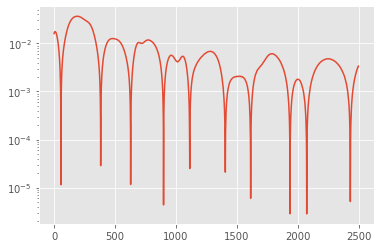

In [34]:
print(np.mean(abs(errors[library_diff_order:-library_diff_order])))
plt.semilogy(abs(errors.flatten()))

#### Discovered X Prediction

Unlike before, as the terms included in the discovered model cannot be assumed from the number of terms, the sparsity mask must be included when `equation_residuals(...)` is called so that a residual based on the terms selected in the discovered model can be calculated.

In [35]:
errors = VE_datagen.equation_residuals(scaled_time_array, predict_voltage_array, predict_current_array, final_coeffs_array, sparsity_mask=sparsity_mask_array, diff_order=library_diff_order)

0.0013203479450371322


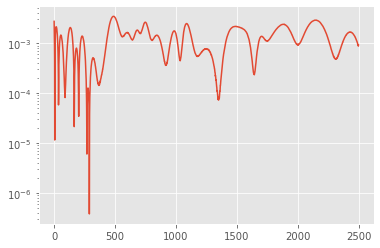

In [36]:
print(np.mean(abs(errors[library_diff_order:-library_diff_order])))
plt.semilogy(abs(errors.flatten()))

### Reformulation of response from discovered model and fit manipulation.

In this final analysis, a response curve is synthesized as a numerical solution to the discovered model, with no reference to the defined model, to examine in another way whether any differences between the models expected and discovered are manifested in a meaningful way.

This analysis is not based on Boltzmann integrals and the differential equation is solved directly and numerically by the SciPy implemented numerical solver `odeint(...)` within the `scipy.integrate` package, and based on FORTRAN libraries.

In this analysis, because no smooth definition of the manipulation is available, the neural network mediated fit of the voltage is taken as dogma. This is represented by the inclusion of `model.network` as an argument.

Intial values for the response for this analysis are obtained from automatic differentiation based on the linked tensors, `time_tensor_post` and `full_prediction_tensor[:, 1]`, the latter of which is the prediction of the current from the full time series available.

The derivatives for the manipulation variable are obtained using automatic differentiation with the provided network in this process, with the primary focus being on solving for the response variable.

In [ ]:
response_recalc = VE_datagen.calculate_int_diff_equation(time_tensor_post, full_prediction_tensor[:, 1], model.network, final_coeffs_array, sparsity_mask_array, library_diff_order, input_type)

In [ ]:
plt.plot(time_array.flatten(), scaled_target_array.flatten(), label='Target')
plt.plot(time_array.flatten(), response_recalc.flatten(), label='Reformulation', marker='.', markersize=1, linestyle='None')
plt.legend()